In [9]:
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import re
import pprint

def exp_func(t, a, b, tau):
    """
    Function to be used for the curve fitting 
    Requires:
    * t (float): Time parameter
    * a (float): Baseline value or noise
    * b (float): Pre-exponential factor such that a + b * exp(-0/tau) ~ peak val
    * tau (float): Lifetime
    Returns:
    result (float): Returns the result of the operation a + b*np.exp(-t/tau)
    """
    
    result = a + b*np.exp(-t/tau)
    return result

def searcher(string):
    """
    Finds any file with the specified extension
    Requires:
    string (string): A string to search
    """
    
    file = re.compile(r'^[^~$].+\.txt')
    return file.search(string)

def file_adder():
    """
    Returns a list with all the csv files in the local directory
    Returns:
    * files (list): A list containing the full paths of the files
    * filenames (list): A list containing the names of the files only plus the string ".png"
    """
    
    directory = os.getcwd()
    files =[]
    filenames = []
    for elements in os.listdir(directory):
        if searcher(elements):
            files.append(os.path.join(directory, elements))
            filenames.append(elements.strip(".txt")+".png")
    return files, filenames

def file_opener(address, separator):
    """
    Opens the file in the specified address and splits them around the set separator. 
    Requires:
    * address (string): The location of the file as found file adder
    * separator (string): The type of separator for the data. "\t" for tab, " " for space, "\n" for newline, "," for commas,
    etc.
    """
    
    file_handle = open(address, "r")
    result = []
    for lines in file_handle:
        processed = lines.split(separator)
        try: #Attempts to convert to number
            float(processed[0])
            part1 = float(processed[0].strip("\n").strip(" "))
            part2 = float(processed[1].strip("\n").strip(" "))
            result.append((part1, part2))
        except: #If unable to convert to number, move to the next line
            continue
        
    return result

def process_data(list_of_tuples, figname, displayfig = True, savefig = False):
    """
    Converts the exponential decay of the sample to lifetime ms, displays fig and saves fig (if enabled)
    Requires:
    * list_of_tuples (list): List with the data in the format (time, intensity counts)
    * figname (string): A list with the names for the figure, in this case taken from the filename
    * displayfig (bool): If set to true will display the plot of the curve fitting (red) vs the measurements (blue pixels),
    the default is set to True
    * savefig (bool): Will save the previous figure as a .png file in the current directory, default set to false
    
    Returns:
    * popt (numpy array): The curve fitting values for a, b and tau
    * pcov (numpy array): Estimated covariance of the parameters
    """
    
    sz = len(list_of_tuples) #Initial size, the same as the number of measurements
    x_data = np.zeros(sz)
    y_data = np.zeros(sz)
    count = 0
    for elements in list_of_tuples: #Set the x and y_data
        x_data[count] = elements[0]
        y_data[count] = elements[1]
        count += 1
    count = 0
    max_val = np.argmax(y_data) #Find the max value point. This is approximately the starting position of the decay
    len_of_y_data = len(y_data[max_val:]) #Find the new size of y_data
    y_data = y_data[max_val:] #Start data from max to the end
    x_data = x_data[:len_of_y_data] #start data from 0 to length of y_data
    sigma_val = np.ones(len_of_y_data)
    sigma_val[0] = 0.01 #Forces a close fit on the first value
    
    #Curve fit using bounded Trust Region Reflective algorithm
    popt, pcov = curve_fit(exp_func, 
                x_data, 
                y_data, 
                p0 = (np.average(y_data[int(len(y_data) * 2/3):]), np.amax(y_data), 1.0e4), #Guess start, not necessary
                sigma = sigma_val, #Uncertainty of each data point calculated with respect to the fit calculated
                                    #as r = ydata - f(xdata, *popt). Note sig equal to 1 means disabled
                absolute_sigma = False, #True = sigma evaluated as an absolute value, False: sigma evaluated as rel. value
                maxfev = 100000,
                    #bounds: a = 0 to 1.5 times noise, b = 0 to 1.5 times max val, tau = 0 to 100 ms, this should cover
                    #pretty much every case
                bounds = ([0., 0., 0.], [np.average(y_data[int(len(y_data) * 2/3):]) * 1.5, np.amax(y_data) * 1.5, 100e6]),
                #Method: trf generally robust method, requires boundaries, if boundaries not known use lm
                method = 'trf') #lm =  Levenberg-Marquardt alg., trf = Trust Region Reflective alg., dogbox = dogleg alg.
    
    plt.plot(x_data, exp_func(x_data, *popt), 'r-', label='curve fit') 
    plt.plot(x_data, y_data, 'b,', label='Measured data')
    plt.title(figname)
    plt.xlabel('time in ns')
    plt.ylabel('Counts')
    plt.legend()
    if savefig == True:
        plt.savefig(figname)
    if displayfig == True:
        plt.show()
    return popt, pcov

def return_lifetime_ms(separator, displayfig = True, savefig = False):
    """
    Calculates the lifetime in milliseconds and returns the % standard deviation of each parameter.
    Requires:
    * separator (string): The type of separator in the data, typically "\t" or ","
    * displayfig (bool): If set to true will display the plot of the curve fitting (red) vs the measurements (blue pixels),
    the default value is True
    * savefig (bool): Will save the previous figure as a .png file in the current directory, default set to false
    
    Returns:
    * result: list with (figname, lifetime in milliseconds)
    * result_cov: list with 3 element tuples of (figname, a-b-tau value, standard deviation in percentage)
    """
    
    lifetimes = []
    covariance = []
    result_cov = []
    result = []
    file_list, fignames = file_adder()
    count = 0
    for file in file_list:
        list_of_tuples = file_opener(file, separator)
        popt, pcov = process_data(list_of_tuples, fignames[count], displayfig, savefig)
        lifetimes.append((popt[2]/1e6))
        cov = np.sqrt(np.diag(pcov))
        cov = cov * 100 / popt
        covariance.append((popt,cov))
        count += 1
    count = 0
    for elements in lifetimes:
        lifetimes[count] = float(str(round(elements, 2))[0:4])
        result.append((fignames[count], lifetimes[count]))
        result_cov.append((fignames[count], covariance[count][0], covariance[count][1]))
        count += 1
    return result, result_cov

def save_data(filename, separator, displayfig = False, savefig = False):
    """
    Reads the lifetime data from all the files in the current folder, extracts the lifetime and standard deviation of all
    params, and writes it in a file
    Requires:
    filename (string): Name of the file where the data will be saved
    separator (string): Type of separator used in the lifetime files. Typically "\t"
    displayfig (bool): Choose whether to display the figure or not. Default set to false
    savefig (bool): Choose whether to save the figure as a .png file
    Returns:
    Does not return anything
    """
    
    lifetime, cov = return_lifetime_ms(separator, displayfig, savefig)
    file_handle = open(filename, "w")
    file_handle.write(
    "Figure_name\tLifetime_(ms)\ta\ta_standard_deviation_%\tb\tb_standard_deviation_%\ttau\ttau_standard_deviation_%\n")
    for i in range(0, len(lifetime),1):
        file_handle.write(
        lifetime[i][0]+"\t"+str(lifetime[i][1])+"\t"+str(cov[i][1][0])+"\t"+str(cov[i][2][0])+"\t"+str(cov[i][1][1])+"\t"\
        +str(cov[i][2][1])+"\t"+str(cov[i][1][2])+"\t"+str(cov[i][2][2])+"\n")
        
    return
    
    

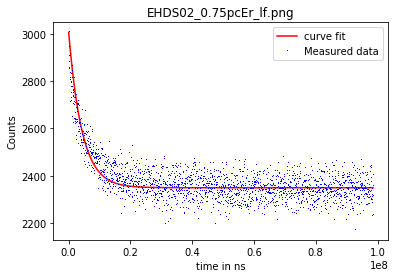

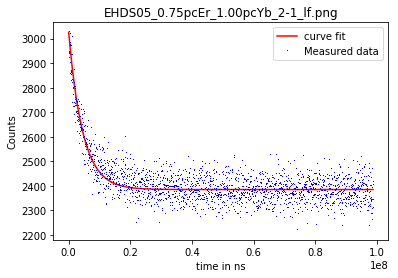

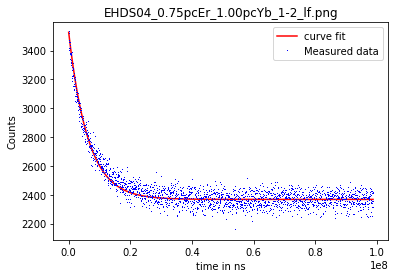

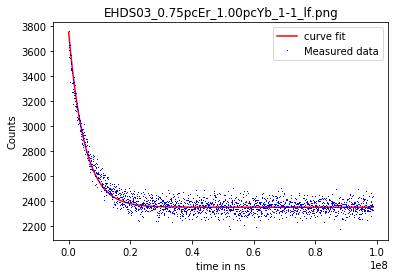

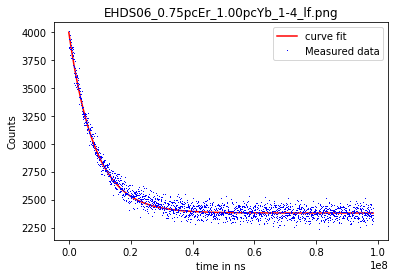

In [10]:
#save_data("results.csv", "\t", False, False) #arguments are (filename, separator, displayfig, savefig)
save_data("results.csv", ";", True, True) #arguments are (filename, separator, displayfig, savefig)
